# Clustering

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
PROCESSED = "../data/processed/"
RAW = "../data/raw/"
RANDOM_STATE = 1

In [3]:
df_train = pd.read_csv(f"{PROCESSED}train_features.csv")

In [4]:
X_train = df_train.drop(columns=["Label"])
y_train = df_train["Label"]

In [5]:
# Apply K-Means clustering with K=5

kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE, n_init=10, max_iter=300)
cluster_labels = kmeans.fit_predict(X_train)

print("K-Means clustering completed!")
print(f"Number of clusters: 5")
print(f"Number of samples: {len(cluster_labels)}")
print(f"\nCluster distribution:")
unique, counts = np.unique(cluster_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} samples ({count/len(cluster_labels)*100:.2f}%)")

# Calculate silhouette score
silhouette_avg = silhouette_score(X_train, cluster_labels)
print(f"\nSilhouette Score: {silhouette_avg:.4f}")

K-Means clustering completed!
Number of clusters: 5
Number of samples: 50587

Cluster distribution:
  Cluster 0: 2195 samples (4.34%)
  Cluster 1: 9617 samples (19.01%)
  Cluster 2: 23691 samples (46.83%)
  Cluster 3: 9354 samples (18.49%)
  Cluster 4: 5730 samples (11.33%)

Silhouette Score: 0.0038


In [14]:
# Load raw training texts for inspection
df_train_raw = pd.read_csv(f"{RAW}train.csv").reset_index(drop=True)
train_texts_raw = df_train_raw['Text'].tolist()
train_labels_raw = df_train_raw['Label'].tolist()

# Get centroids
centroids = kmeans.cluster_centers_

print("=" * 80)
print("Documents Closest to Each Centroid")
print("=" * 80)

semantic_labels = {}
num_closest = 3  # Number of valid closest documents to show

for cluster_id in range(5):
    centroid = centroids[cluster_id]
    
    # Calculate distances from all points to this centroid
    distances = cdist([centroid], X_train.values, metric='euclidean')[0]
    
    # Sort all document indices from closest to furthest
    sorted_indices = np.argsort(distances)
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*80}")
    
    # Cluster statistics
    cluster_mask = cluster_labels == cluster_id
    cluster_true_labels = y_train[cluster_mask]
    fake_count = np.sum(cluster_true_labels == 0)
    real_count = np.sum(cluster_true_labels == 1)
    
    print(f"\nCluster Statistics:")
    print(f"  Total documents in cluster: {np.sum(cluster_mask)}")
    print(f"  Fake news: {fake_count} ({fake_count/np.sum(cluster_mask)*100:.1f}%)")
    print(f"  Real news: {real_count} ({real_count/np.sum(cluster_mask)*100:.1f}%)")
    
    print(f"\n{num_closest} Closest Documents (Valid Texts Only):")
    print("-" * 80)
    
    # There were a lot of rows where text is "NONE". We considered those documents uninformative
    # and decided to only inspect those whose text was not "NONE"
    valid_count = 0
    for idx in sorted_indices:
        if valid_count >= num_closest:
            break
        
        # Check index bounds
        if idx >= len(train_texts_raw):
            continue
        
        text = train_texts_raw[idx]
        true_label = train_labels_raw[idx]
        
        # Skip missing, empty, or literal "NONE" texts
        if not isinstance(text, str) or len(text.strip()) == 0 or text.strip().upper() == "NONE":
            continue
        
        valid_count += 1
        display_text = text[:300] + "..."
        
        print(f"\nDocument {idx} (Distance: {distances[idx]:.2f}, Label: {'Fake' if true_label == 0 else 'Real'}):")
        print(f"text length: {len(text)}")
        print(f"  {display_text}")
    
    if fake_count > real_count * 1.5:
        suggested_label = "Fake News Dominant"
    elif real_count > fake_count * 1.5:
        suggested_label = "Real News Dominant"
    else:
        suggested_label = "Mixed Content"
    
    semantic_labels[cluster_id] = suggested_label
    print(f"\nSuggested Semantic Label: {suggested_label}")

print("\n" + "=" * 80)
print("Semantic Labels Assigned:")
print("=" * 80)
for cluster_id, label in semantic_labels.items():
    print(f"  Cluster {cluster_id}: {label}")




Documents Closest to Each Centroid

CLUSTER 0

Cluster Statistics:
  Total documents in cluster: 2195
  Fake news: 115 (5.2%)
  Real news: 2080 (94.8%)

3 Closest Documents (Valid Texts Only):
--------------------------------------------------------------------------------

Document 931 (Distance: 0.40, Label: Fake):
text length: 17
  "Fuck you Greta!"...

Document 41275 (Distance: 0.40, Label: Fake):
text length: 36
  "@atchouameni
@Camavinga
@KMbappe"...

Document 25447 (Distance: 0.40, Label: Fake):
text length: 30
  "Problematizaram o cafézinho!"...

Suggested Semantic Label: Real News Dominant

CLUSTER 1

Cluster Statistics:
  Total documents in cluster: 9617
  Fake news: 8029 (83.5%)
  Real news: 1588 (16.5%)

3 Closest Documents (Valid Texts Only):
--------------------------------------------------------------------------------

Document 931 (Distance: 0.34, Label: Fake):
text length: 17
  "Fuck you Greta!"...

Document 41275 (Distance: 0.34, Label: Fake):
text length: 36
  "@at

PCA Explained Variance Ratio:
  PC1: 0.0091 (0.91%)
  PC2: 0.0086 (0.86%)
  Total: 0.0178 (1.78%)


/Users/guilhermejose/Repositories/NTT-DATA-challenge/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


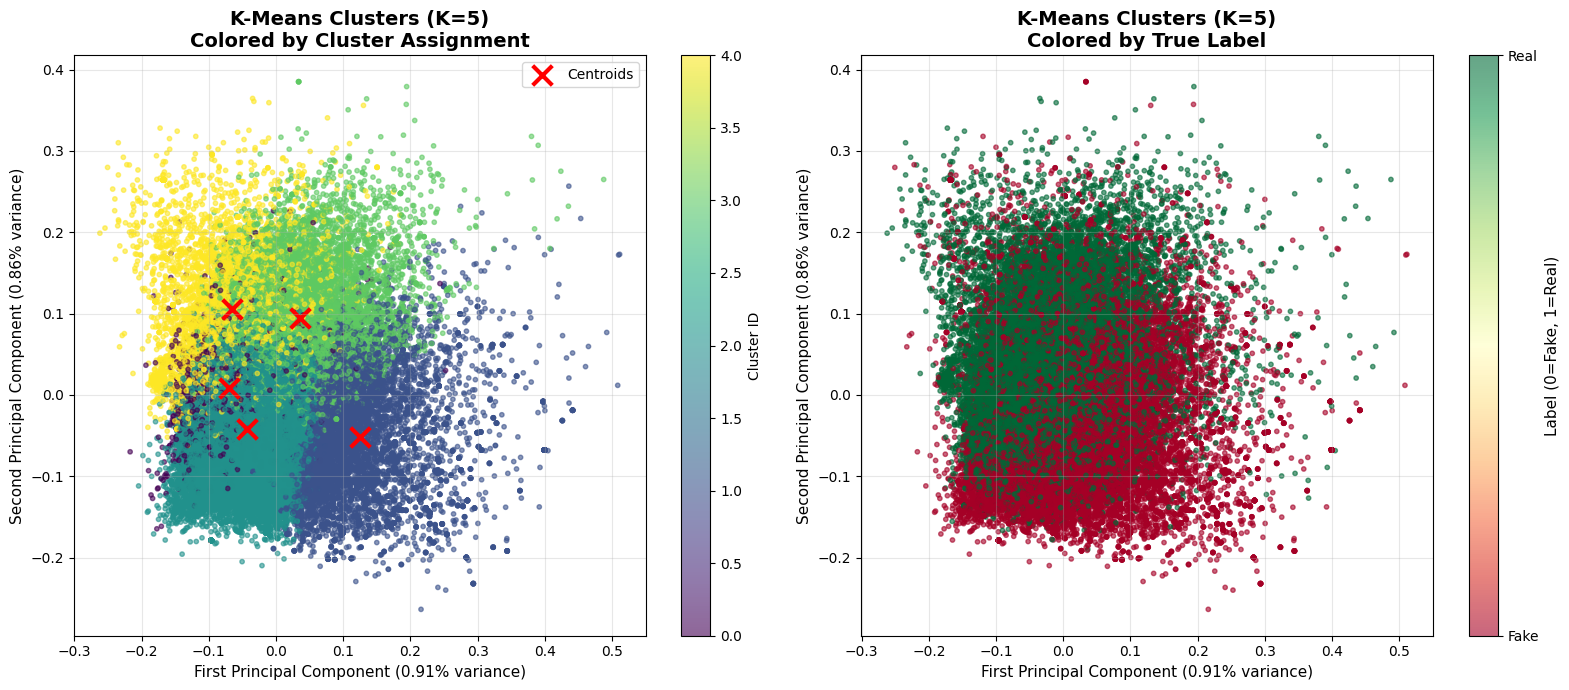


Cluster-Label Alignment Analysis

Cluster 0 (Real News Dominant):
  Fake news: 5.2%
  Real news: 94.8%
  Purity: 94.8%

Cluster 1 (Fake News Dominant):
  Fake news: 83.5%
  Real news: 16.5%
  Purity: 83.5%

Cluster 2 (Mixed Content):
  Fake news: 46.6%
  Real news: 53.4%
  Purity: 53.4%

Cluster 3 (Mixed Content):
  Fake news: 40.6%
  Real news: 59.4%
  Purity: 59.4%

Cluster 4 (Real News Dominant):
  Fake news: 39.0%
  Real news: 61.0%
  Purity: 61.0%


In [7]:
# Apply PCA to reduce to 2D
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_train)

print(f"PCA Explained Variance Ratio:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.4f} ({pca.explained_variance_ratio_[0]*100:.2f}%)")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.4f} ({pca.explained_variance_ratio_[1]*100:.2f}%)")
print(f"  Total: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Colored by cluster assignment
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=10)
ax1.set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]*100:.2f}% variance)', fontsize=11)
ax1.set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]*100:.2f}% variance)', fontsize=11)
ax1.set_title('K-Means Clusters (K=5)\nColored by Cluster Assignment', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Cluster ID')

# Plot centroids
centroids_pca = pca.transform(centroids)
ax1.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='x', s=200, linewidths=3, label='Centroids')
ax1.legend()

# Plot 2: Colored by true label
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='RdYlGn', alpha=0.6, s=10)
ax2.set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]*100:.2f}% variance)', fontsize=11)
ax2.set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]*100:.2f}% variance)', fontsize=11)
ax2.set_title('K-Means Clusters (K=5)\nColored by True Label', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
cbar = plt.colorbar(scatter2, ax=ax2)
cbar.set_label('Label (0=Fake, 1=Real)', fontsize=11)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Fake', 'Real'])

plt.tight_layout()
plt.show()

# Analyze cluster-label alignment
print("\n" + "=" * 80)
print("Cluster-Label Alignment Analysis")
print("=" * 80)
for cluster_id in range(5):
    cluster_mask = cluster_labels == cluster_id
    cluster_true_labels = y_train[cluster_mask]
    fake_pct = np.sum(cluster_true_labels == 0) / len(cluster_true_labels) * 100
    real_pct = np.sum(cluster_true_labels == 1) / len(cluster_true_labels) * 100
    
    print(f"\nCluster {cluster_id} ({semantic_labels[cluster_id]}):")
    print(f"  Fake news: {fake_pct:.1f}%")
    print(f"  Real news: {real_pct:.1f}%")
    print(f"  Purity: {max(fake_pct, real_pct):.1f}%")